# Transverse Ising Model

The transverse field Ising model is a particular version of the Ising model, the world's best known ferromagnet toy model. The 1D and 2D Ising models are important due to their integrability and their relation to phase transitions, and they have connections with many combinatorics and optimisation problems. What is particular about the 1D transverse model is the fact that it involves non-commuting Pauli operators, and thus is harder to analyse. It is a frequent case study in quantum computing &mdash; in this notebook I try examine its ground state at different field intensities. There are a few different approaches to studying ground sates on a quantum computer: imaginary time evolution, quantum phase estimation... here I'll apply a Variational Quantum Eigensolver (VQE).

Let's import some necessary libraries.

In [232]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

### The model

Our model of interest is a 1D spin chain with nearest-neighbour interactions (strength $J$) and external magnetic field in a transversal direction (strength $h$). Its Hamiltonian reads

$$
H = -J\sum\limits_{i=1}^N\sigma^z_i\sigma^z_{i+1} - h\sum\limits_{i=1}^N\sigma^x_i
$$

where $\sigma^z_i$, $\sigma^x_i$ are Pauli $z$ and $x$ matrices, respectively, operating on the $i^{th}$ particle. The imposed boundary conditions are periodic, i.e. the chain wraps around itself, the particles live on a ring. We can directly implement this operator in Qiskit &mdash; let's do so, as it'll be convenient later on.

In [233]:
from qiskit.quantum_info import SparsePauliOp

def hamiltonian(J, h, N):
    spin_coupling = []
    s_coefs = - J*np.ones(N) 
    transverse_field = []
    f_coefs = - h*np.ones(N) 
    for i in range(N - 1):
        spin_coupling.append(i*'I' + 'ZZ' + (N - 2 - i)*'I')
        transverse_field.append(i*'I' + 'X' + (N - 1 - i)*'I')
    spin_coupling.append('Z' + (N - 2)*'I' + 'Z')
    transverse_field.append((N - 1)*'I' + 'X')
    H = SparsePauliOp([*spin_coupling, *transverse_field], [*s_coefs, *f_coefs])
    return H

# Example/test
hamiltonian(1, 1, 4)

SparsePauliOp(['ZZII', 'IZZI', 'IIZZ', 'ZIIZ', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])

The Hamiltonian has a $\mathbb{Z}_2$ symmetry [2]  (i.e. the two operators it commutes with form the $\mathbb{Z}_2$ cyclic group). Specifically, it commutes with the identity $I^{\otimes N}$ and $R_x=\sigma_x^{\otimes N}$, since

$$
R_x\sigma^z_jR_x^\dagger=-\sigma^z_j \qquad\qquad\qquad R_x\sigma^x_jR_x^\dagger=\sigma^x_j
$$

The $R_x$ operator essentially flips all spins (in the z basis). The model then admits two phases depending on whether the ground state breaks or preserves the symmetry:

- **Ordered phase / ferromagnet** ($|h/J|<1$): If $|\psi_1\rangle$ is a ground state of the system, then so is $|\psi_2\rangle=R_x|\psi_1\rangle$. The spin flip symmetry is broken. This means the lowest energy subspace is degenerate and is given by $\mathrm{span}\{|\psi_1\rangle, |\psi_2\rangle\}$.
- **Disordered phase / paramagnet** ($|h/J|>1$): The symmetry is preserved and the ground state is nondegenerate.

There is then a phase transition at $|h/J|=1$.

If we can approximate the ground state wavefunction, we might as well use it to measure certain quantities in the ground state. In particular, let's measure the magnetisation along the z and x directions.

In [234]:
def magnetisation_z(N):
    ops = []
    for i in range(N):
        ops.append(i*'I' + 'Z' + (N - 1 - i)*'I')
    Mz = SparsePauliOp(ops, np.ones(N) /N)
    return Mz

def magnetisation_x(N):
    ops = []
    for i in range(N):
        ops.append(i*'I' + 'X' + (N - 1 - i)*'I')
    Mx = SparsePauliOp(ops, np.ones(N) / N)
    return Mx

### VQE

The VQE is an algorithm adapted to the Noisy Intermediate Scale Quantum (NISQ) era. It consists in computing an expensive cost function (in our case the Hamiltonian, which has a dimension exponential in the number of qubits) on a quantum computer, and minimising it on a classical computer. We essentially apply the Rayleigh-Ritz variational method to calculate an upper bound for the ground state energy:

$$
E(\vec{\theta})=\langle\psi(\vec{\theta})|H|\psi(\vec{\theta})\rangle\geq E_0
$$

To get good results we therefore need a good ansatz $|\psi(\vec{\theta})\rangle$ (parametrised guess of the ground state). This ansatz is built by applying a series of parametrised quantum gates, $U(\vec{\theta})$, to the $|0\rangle^{\otimes N}$ state. Given the degeneracy discussed above, Ref. [1] suggests preparing a state 

$$
|\psi(\vec{\theta})\rangle=(\alpha+\beta R_x)|\varphi(\vec{\theta})\rangle
$$

The exact circuit is shown below.

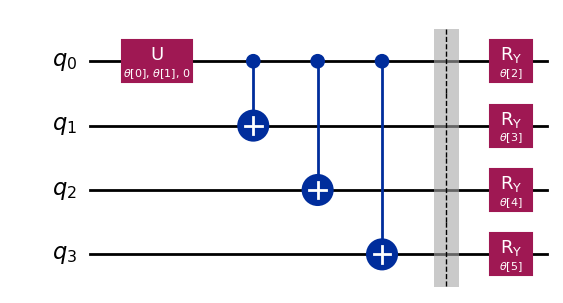

In [235]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import Parameter

def ansatz(N):
    theta = [Parameter(fr'$\theta[{i}]$') for i in range(N+2)]
    qr = QuantumRegister(N, name='q')
    qc = QuantumCircuit(qr)
    qc.u(theta[0], theta[1], 0, qubit=0)
    for i in range(1, N):
        qc.cx(0, i)
    qc.barrier()
    for i in range(N):
        qc.ry(theta[i+2], qubit=i)
    return qc

# Example/test
ansatz(4).draw('mpl', style='iqp')

Now that we have our ansatz, coding an optimisation routine is easy. For the sake of simplicity, we'll use SciPy's already existing `minimize` to find the optimal parameters and energy of our trial wavefunction. For comparison with exact results in the next section, and also convenience (we would like to study dimensionless, intesive quantities), we'll calculate the energy per spin site, in units of $J$.

In [236]:
from qiskit.primitives import Estimator
from scipy.optimize import minimize

def cost_function(params, ansatz, hamiltonian, estimator):
    return estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]

@np.vectorize()
def ground_VQE(J, h, N, tries=10):
    estimator = Estimator()
    results = []
    for _ in range(tries):
        theta0 = np.zeros(0, N+2)
        results.append(minimize(cost_function, theta0, args=(ansatz(N), hamiltonian(J, h, N), estimator)))
    true_min = np.argmin([result.fun for result in results])
    result = results[true_min]
    E = result.fun / (N*J)
    Mz = estimator.run(ansatz(N), magnetisation_z(N), parameter_values=result.x).result().values[0]
    Mx = estimator.run(ansatz(N), magnetisation_x(N), parameter_values=result.x).result().values[0]
    return E, np.abs(Mz), Mx

### Exact solution

It just so happens that the 1D transverse Ising model is exactly solvable in the thermodynamic limit (see [3]). Here I provide the formulas (bear in mind that the Pauli matrices in the paper differ by factors of $1/2$ from the ones I have used, and the x, z directions have been swapped):

$$
\frac{E_0}{N h}=-\frac{2}{\pi}(1+\lambda)E(m)
$$

$$
M_z = 
\begin{cases}
    0 & \text{if }\lambda\leq 1/2\\
    \left(1-\frac{1}{4\lambda^2}\right)^{1/8} & \text{if }\lambda>1/2
\end{cases}
$$

where $E(m)$ is the complete elliptic integral of the second kind, $m=\frac{4\lambda}{(1+\lambda)^2}$ and $\lambda=J/h$. Ref. [3] also indirectly gives an expression for $M_x$, which we can develop explicitly.

$$
M_x = L(0)+\lambda L(1),\qquad 
L(n)=\frac{1}{\pi}\int_0^\pi dk\frac{\cos(nk)}{\sqrt{1+\lambda^2+2\lambda\cos(k)}}
$$

$$
L(0) = \frac{2}{\pi(1+\lambda)}\int_0^1 dt\frac{1}{\sqrt{(1-t^2)(1-\frac{4\lambda}{(1+\lambda)^2}t^2)}}=
\frac{2}{\pi(1+\lambda)}K(m)
$$

$$
L(1) = \frac{2}{\pi(1+\lambda)}\int_0^1 dt\frac{1-2t^2}{\sqrt{(1-t^2)(1-\frac{4\lambda}{(1+\lambda)^2}t^2)}}=
\left(\frac{2}{\pi(1+\lambda)}-\frac{1+\lambda}{\pi\lambda}\right)K(m)+\frac{1+\lambda}{\pi\lambda}E(m)
$$

where $K(m)$ is the complete elliptic integral of the first kind. All in all:

$$
M_x = \frac{2}{\pi}K(m)+\frac{1+\lambda}{\pi}(E(m)-K(m))
$$

As a final step, we can use the exact solution for the ground state to compare to our VQE simulation.

In [237]:
def ground_energy_exact(lambd):
    m = 4 * lambd / (1 + lambd)**2
    return - 2 / np.pi * (1 + 1 / lambd) * sp.ellipe(m) 

@np.vectorize()
def magnetisation_z_exact(lambd):
    if lambd <= .5:
        return 0
    return (1 - 1 / (4 * lambd**2)) ** (1/8)

def magnetisation_x_exact(lambd):
    m = 4 * lambd / (1 + lambd)**2
    K = sp.ellipk(m)
    E = sp.ellipe(m)
    return (2 * K + (1 + lambd) * (E - K)) / np.pi

In [238]:
J = 1
hmax = 4
N = 4

# Variational solution
h = np.linspace(0, hmax, 10)
E_VQE, Mz_VQE, Mx_VQE = ground_VQE(J, h, N)

# Exact solution
h_smooth = np.linspace(1e-8, hmax, 200)
lambd = J / h_smooth
E_exact = ground_energy_exact(lambd)
Mz_exact = magnetisation_z_exact(lambd)
Mx_exact = magnetisation_x_exact(lambd)

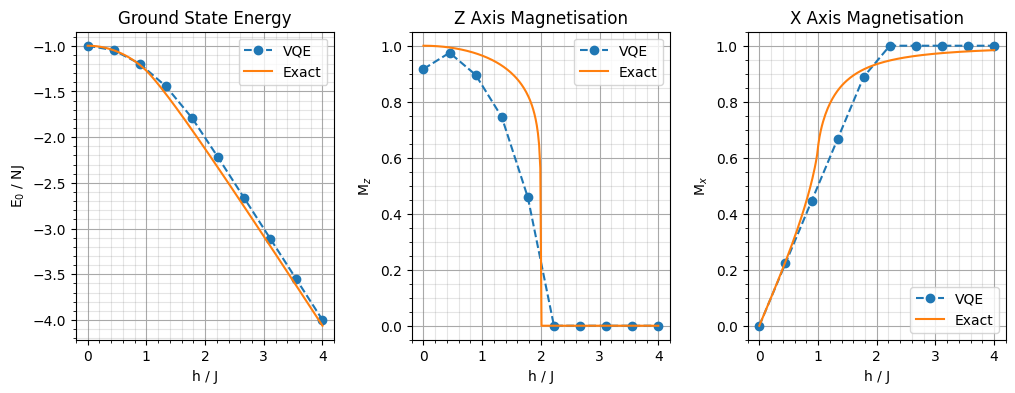

In [239]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(wspace=.3)
ax[0].set_title('Ground State Energy')
ax[0].plot(h / J, E_VQE, 'o--', label='VQE')
ax[0].plot(h_smooth / J, E_exact, label='Exact')
ax[0].set_xlabel('h / J')
ax[0].set_ylabel('E$_0$ / NJ')
ax[1].set_title('Z Axis Magnetisation')
ax[1].plot(h / J, Mz_VQE, 'o--', label='VQE')
ax[1].plot(h_smooth / J, Mz_exact, label='Exact')
ax[1].set_xlabel('h / J')
ax[1].set_ylabel('M$_z$')
ax[2].set_title('X Axis Magnetisation')
ax[2].plot(h / J, Mx_VQE, 'o--', label='VQE')
ax[2].plot(h_smooth / J, Mx_exact, label='Exact')
ax[2].set_xlabel('h / J')
ax[2].set_ylabel('M$_x$')
for axis in ax:
    axis.legend()
    axis.grid(which='major', color='darkgrey', linestyle='-')
    axis.grid(which='minor', color='grey', linestyle='-', alpha=0.2)
    axis.minorticks_on()

As can be seen, we approximate the ground state of our model reasonably well with the chosen tolerances. Better tolerances, more qubits (since the exact result is for $N\rightarrow\infty$) and a better ansatz (especially one that behaves better at intermediate field strengths and near the critical point) would likely lead to a better result. This serves as motivation to apply similar techniques to classically intractable problems, for which quantum computers show promise.

### References

[1] Abhijith J. *et al.* (2022). Quantum Algorithm Implementations for Beginners. *ACM Transactions on Quantum Computing, 3(4), 1–92*. Retrieved from https://arxiv.org/pdf/1804.03719.pdf

[2] McGreevy, J. (2021). Physics 239a: Where do quantum field theories come from? *University of California San Diego*. Retrieved from https://mcgreevy.physics.ucsd.edu/s14/239a-lectures.pdf

[3] Pfeuty, P. (1970). The one-dimensional Ising model with a transverse field. *Annals of Physics, 57(1), 79-90*. Retrieved from https://www.math.ucdavis.edu/~bxn/pfeuty1970.pdf